### Lets read the results

In [3]:
import pandas as pd
import re
import json
from collections import Counter
from nltk.corpus import stopwords
import nltk

import emoji
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

import os

In [27]:
RemoveStops(three, 'english')

'pizza hut favorite restaurant'

In [16]:
all_words = []
one = 'hello i love pizza'
two = 'where is my pizza delivery guy'
three = 'pizza hut is my favorite restaurant'


    
for sentence in [one,two,three]:
    cleaned_sentence = RemoveStops(sentence, 'english')    
    for word in cleaned_sentence.split(' '):
        all_words.append(word)

In [28]:
pd.DataFrame({ 'doc_one' : {'delivery' : 0, 'favorite' : 0, 'guy' : 0, 'hello' : 1, 'hut' : 0, 'love': 1, 'pizza' : 1, 'restaurant' : 0},
 'doc_two' : {'delivery' : 1, 'favorite' : 0, 'guy' : 1, 'hello' : 0, 'hut' : 0, 'love': 0, 'pizza' : 1 , 'restaurant' : 0},
 'doc_three' : {'delivery' : 0, 'favorite' : 1, 'guy' : 0, 'hello' : 0, 'hut' : 1, 'love' : 0, 'pizza': 1, 'restaurant' : 1} }).transpose()

,delivery,favorite,guy,hello,hut,love,pizza,restaurant
doc_one,0,0,0,1,0,1,1,0
doc_two,1,0,1,0,0,0,1,0
doc_three,0,1,0,0,1,0,1,1


In [4]:
def folderCompProfiles(comp_name):
    """Searches in the data folder to search for followerProfiles on the name of this company."""
    #Get all the followerProfiles
    followerProfiles = [value for value in os.listdir("insta_followerprofile/data") if 'followerProfile' in value]
    company_followerProfiles = [value for value in followerProfiles if comp_name + '_' in value]
    return company_followerProfiles

folderCompProfiles('voetbaldirect')

['voetbaldirect_followerProfile.csv',
 'voetbaldirect_second_followerProfile.csv']

In [5]:
def mergeRawDataFrame(file_locations):
    """Takes as input a list of file locations. First checks the usernames present in all files and notifies
    the user if there is an overlap. After this it merges all the follower profiles."""
    df = pd.DataFrame()
    name_buffer = {}
    for followerProfile in file_locations:
        temp_df = pd.read_csv("insta_followerprofile/data/" + followerProfile)
        names = [value for value in set([value for value in temp_df['data.user.edge_owner_to_timeline_media.edges.node.owner.username']])]
        #Small check to see whether names are present in different followerProfiles of the same company.
        for name in names:
            if name in name_buffer.keys():
                print('We have a double name: {}'.format(name))
                name_buffer[name] += 1
            else:
                name_buffer[name] = 1
        df = pd.concat([df, temp_df], ignore_index=True)
    return df

In [6]:
## PLEASE READ: ONLY READ THIS WHEN USING THE NEW WORKFLOW OF STEVESIE DATA. OTHERWISE THE TEMPLATE IS DIFFERENT!

def cleanRawDataFrame(raw_dataframe):
    """Select the desired columns from the raw dataframe and renames the columns."""
    cleaned_df = raw_dataframe[[
         'input.user_id', 
         'data.user.edge_owner_to_timeline_media.edges.node.owner.username', 
         'data.user.edge_owner_to_timeline_media.edges.node.shortcode', 
         'data.user.edge_owner_to_timeline_media.edges.node.edge_media_to_caption.edges[0].node.text', 
         'data.user.edge_owner_to_timeline_media.edges.node.display_url', 
         'data.user.edge_owner_to_timeline_media.edges.node.video_url', 
         'data.user.edge_owner_to_timeline_media.edges.node.edge_media_preview_like.count', 
         'data.user.edge_owner_to_timeline_media.edges.node.edge_media_to_comment.count', 
         'data.user.edge_owner_to_timeline_media.edges.node.video_view_count', 
         'data.user.edge_owner_to_timeline_media.edges.node.taken_at_timestamp']]
    
    new_columnNames = ['userID',
                      'username',
                      'shortcode',
                      'original_text',
                      'display_url',
                      'video_url',
                      'like_count',
                      'comment_count',
                       'view_count',
                      'timestamp']
    
    cleaned_df.columns = new_columnNames
    return cleaned_df

### Create seperate column which indicate occurance of hashtags

In [4]:
from collections import Counter
def cleanUnicode(string):
    """Some simple cleanup applied to a string of text"""
    string = string.lower() #No capital letters
    string = string.replace('\n',' ') # Remove new line commands
    string = string.replace('\xa0',' ') # Remove non-breaking space in Latin
    return string
    
    
def removeHashtags(string):
    """Takes string as input. Removes all words which start with # with length > 2"""
    sentence_words = string.split(' ')
    new_sentence = []
    for word in sentence_words:
        if word[0] == '#' and len(word) > 2:
            continue
        else:
            new_sentence.append(word)
    return ' '.join(new_sentence)
            
    
def extractHashtags(string):
    '''This function simply takes a string as input and analyses all words that start with a hashtag.'''
    buffer = []
    try:
        for value in string.split(' '):
            try:
                if value[0] == '#':
                    #Counter the number of hashtags in the hashtag. If > 0 we need to further split.
                    if dict(Counter(value))['#'] > 1:
                        multiple_hashtags = value.split('#')
                        for hashtag in multiple_hashtags:
                            if len(hashtag) > 2:
                                buffer.append('#' + hashtag)
                    #Only one hashtag in the word? Just add it to the buffer if length > 2.
                    else:
                        if len(value) > 2: buffer.append(value)
            except IndexError:
                continue
    except SyntaxError:
        print('oei')
    return buffer

def extractUser(string):
    '''This function simply takes a string as input and analyses all words that start with a hashtag.'''
    buffer = []
    try:
        for value in string.split(' '):
            try:
                if value[0] == '@':
                    #Counter the number of hashtags in the hashtag. If > 0 we need to further split.
                    if dict(Counter(value))['@'] > 1:
                        multiple_hashtags = value.split('@')
                        for hashtag in multiple_hashtags:
                            if len(hashtag) > 2:
                                buffer.append('@' + hashtag)
                    #Only one hashtag in the word? Just add it to the buffer if length > 2.
                    else:
                        if len(value) > 2: buffer.append(value)
            except IndexError:
                continue
    except SyntaxError:
        print('oei')
    return buffer

def deEmojify(inputString):
    return emoji.get_emoji_regexp().sub(u'', inputString)

def removePunct_ONEWORD(string):
    """This function uses a string of words as input and cleans it as good as it can."""
    string= string.replace('.', ' ')
    temp = re.sub(r'[^\w\s]','',string)
    return temp.replace(' ', '.')

def RemoveStops(string, lang):
    """This takes a string as input, splits it on the spaces and removes the stopwords."""
    stop_words = set(stopwords.words(lang)) 
    temp = [word for word in string.split(" ") if not word in stop_words]
    return ' '.join(temp)

def processText(original_string):
    #Remove capital and some weird unicode.
    string = cleanUnicode(original_string)
    #Extract user mentions and hashtags so we can remove this from the text.
    hashtags = extractHashtags(string)
    userMentions = extractUser(string)
    #Removing the hashtags and user mentions seperately from the list of words.
    string_noHashtags = [value for value in word_tokenize(string) if '#' + value not in hashtags]
    string_noUsers = [value for value in string_noHashtags if value[1::] not in userMentions]
    #Add all words together into a sentence if the word length > 1. (remove punc etc.)
    processed_text =  ' '.join([value for value in string_noUsers if len(value) > 1])
    #Finally remove the emoticons and we are done!
    hashtags_cleaned = [removePunct_ONEWORD(value) for value in hashtags]
    userMentions_cleaned = [removePunct_ONEWORD(value) for value in userMentions]
    #Now lets remove some dutch and English stopwords from the processed text.
    processed_text_noStops = RemoveStops(RemoveStops(processed_text, 'dutch'), 'english')
    #Finally remove the emoticons from the no stopwords text and we are done!
    processed_text_noEmoticons = deEmojify(processed_text_noStops)
    return [original_string, processed_text_noEmoticons, hashtags_cleaned, userMentions_cleaned]

In [8]:
def createProcessedSenteceDF(followerProfile_sentences):
    """Takes the written texts of the posts from a followerProfile as input. Extract hashtags and usernames to
    create three seperate columns in the dataframe to increase processing."""
    df_buffer = []
    for sentence in sentences:   
        #If the text is just NaN (float) we want to skip it.
        if isinstance(sentence, float) == True:
            df_buffer.append(['', '', '', ''])
        else:
            df_buffer.append(processText(sentence))

    return pd.DataFrame(df_buffer)

In [12]:
company_names = ["madedotcom", "vtwonen", "hemanederland", "loods5", "ikeanederland", "homify", "westwingnl", 
"karwei", "kwantum_nederland", "xenos_nl", "homedeco", "bol_com", "leenbakker", "wonenmetlef", "_connox_",
"interiorjunkiecom", "jysknl", "wehkamp", "fonqnl", "konforhome", "basiclabel.nl", "blokker",
"deensnl", "hastensbeds", "eijerkamp", "goossenswonenenslapen", "furn.nl", "stoermetaal", "roomednl", "misterdesignnl",
"dekbeddiscounter", "woonexpress", "zitmaxx", "pronto_wonen", "designbestseller", "barbecueshop.nl",
"flinders.design", "trendhopper", "debommelmeubelen", "otto_nl", "praxis_bouwmarkt", "gamma_nl",
"pietklerkx.nl", "swisssense", "montelwonen", "aupingnl", "hacowonenenslapen", "emma_matras", "hornbachnl",
"lampenlicht.nl", "profijtmeubel", "bianonl", "woonboulevardpoortvliet", "morreswonen", "hubo_nl", "beter_bed",
"hoogenboezem.meubelen", "villajipp_outlet", "vidaxl_nl", "mline_nl"]

food_companies = ["veganjunkfoodbar", "pastaebasta_amsterdam", "mamakellyamsterdam", "watsonsfood",
"cannibaleroyale", "parkheuvel", "restaurantfred", "hugh_rotterdam", "oldscuola", "restaurantkite",
"wturbankitchen", "thestreetfoodclub", "rumclubutrecht", "lejardinutrecht", "broei.utrecht"]

sport_companies = ["plutosport.nl", "voetbalshopnl", "all4runningstore", "voetbaldirect",
"dakasport", "hockeydirect.nl", "tennisdirect", "intersportnl", "aktiesport.nl", "sport2000nederland",
"soccerfanshop", "jdsportsnl", "decathlonnederland", "gorillasportsnl", "perrysport.nl"]

In [11]:
for comp_name in sport_companies:    
    #Find all company follower profiles in the data folder
    company_followerProfiles = folderCompProfiles(comp_name)
    #Merge all company follower profiles in one final dataframe
    cleaned_df = mergeRawDataFrame(company_followerProfiles)
    #Give the columns of the new dataframe the desired column names.
    cleaned_df = cleanRawDataFrame(cleaned_df)
    #Storing all the texts of all posts under one variable name
    sentences = [value for value in cleaned_df['original_text']]
    #Creating a new dataframe which contains all the processed posts
    cleaned_sentence_df = createProcessedSenteceDF(sentences)
    #Add these columns of the cleaned sentence dataframe to the cleaned dataframe we already have
    cleaned_df['cleaned_text'] = [value for value in cleaned_sentence_df[1]]
    cleaned_df['hashtags'] = [value for value in cleaned_sentence_df[2]]
    cleaned_df['userMsentions'] = [value for value in cleaned_sentence_df[3]]
    #Printing the total number of userIDs from which we extracted the posts now.
    total_userIDS = len(set([value for value in cleaned_df['userID']]))
    #Finally storing the final dataframe in the data folder.\
    print("Finished cleaning profile of {}. Total IDS: {}.".format(comp_name, total_userIDS))
    cleaned_df.to_pickle("insta_followerprofile/data/{}_cleaned.pkl".format(comp_name))

<ipython-input-5-c29f81a2966e>:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, temp_df], ignore_index=True)


Finished cleaning profile of perrysport.nl. Total IDS: 2003.


In [13]:
def check_IDS(comp_name):
    #Find all company follower profiles in the data folder
    company_followerProfiles = folderCompProfiles(comp_name)
    #Merge all company follower profiles in one final dataframe
    cleaned_df = mergeRawDataFrame(company_followerProfiles)
    #Give the columns of the new dataframe the desired column names.
    cleaned_df = cleanRawDataFrame(cleaned_df)
    total_userIDS = len(set([value for value in cleaned_df['userID']]))
    print("{} - {}".format(comp_name, total_userIDS))
    return 

for comp in sport_companies:
    check_IDS(comp)

/Users/nielsvangorsel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (89,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-5-c29f81a2966e>:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, temp_df], ignore_index=True)


plutosport.nl - 697


/Users/nielsvangorsel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (88) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/nielsvangorsel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (89) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


We have a double name: mishaa_79_
voetbalshopnl - 1786


/Users/nielsvangorsel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,3,6,8,11,12,13,14,20,22,24,26,31,39,40,41,42,43,46,47,75,76,89,91) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


all4runningstore - 2046


/Users/nielsvangorsel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (88,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


voetbaldirect - 688


/Users/nielsvangorsel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,3,11,13,14,16,19,20,22,23,24,25,27,29,30,31,32,33,34,47,89,90,91,92,93,95) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


dakasport - 1321
hockeydirect.nl - 1549
tennisdirect - 745


/Users/nielsvangorsel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (87,88,89,90,92) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/nielsvangorsel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (88,89,90,91,93) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


intersportnl - 2238


/Users/nielsvangorsel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (88,89,90,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


aktiesport.nl - 2333


/Users/nielsvangorsel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (93) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


sport2000nederland - 937


/Users/nielsvangorsel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,2,6,7,8,12,13,14,16,18,19,21,26,28,29,30,32,33,44,45,88,89,90,91,93,95) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


soccerfanshop - 1913


/Users/nielsvangorsel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/nielsvangorsel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,7,11,12,13,14,16,18,19,21,29,30,31,32,33,50,88,89,90,91,93,95) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


jdsportsnl - 1980
decathlonnederland - 2719
gorillasportsnl - 1059


KeyboardInterrupt: 

In [ ]:
def folderCompProfiles(comp_name):
    """Searches in the data folder to search for followerProfiles on the name of this company."""
    #Get all the followerProfiles
    followerProfiles = [value for value in os.listdir("insta_followerprofile/data") if 'followerProfile' in value]
    company_followerProfiles = [value for value in followerProfiles if comp_name + '_' in value]
    return company_followerProfiles

def mergeRawDataFrame(file_locations):
    """Takes as input a list of file locations. First checks the usernames present in all files and notifies
    the user if there is an overlap. After this it merges all the follower profiles."""
    df = pd.DataFrame()
    name_buffer = {}
    for followerProfile in file_locations:
        temp_df = pd.read_csv("insta_followerprofile/data/" + followerProfile)
        names = [value for value in set([value for value in temp_df['data.user.edge_owner_to_timeline_media.edges.node.owner.username']])]
        #Small check to see whether names are present in different followerProfiles of the same company.
        for name in names:
            if name in name_buffer.keys():
                print('We have a double name: {}'.format(name))
                name_buffer[name] += 1
            else:
                name_buffer[name] = 1
        df = pd.concat([df, temp_df], ignore_index=True)
    return df

In [ ]:
set([value for value in mergeRawDataFrame(folderCompProfiles('vidaxl_nl'))['data.user.edge_owner_to_timeline_media.edges.node.owner.username']])

### Create wordcloud

In [358]:

long_string = ''

for value in list(df['text'].values):
    if len(value) < 1:
        continue
    else:
        long_string += " "+value
        
long_string[1::]

'pizzatime work tijdens bedrijfsbezoek antwerpen deense partner hay prachtige architectonische route langs havenhuis ontworpen architecte dame zaha hadid stedelijk museum mas museum stroom ontworpen neutelings riedijk architecten robby valentine nieuwenor tegekke show robbyvalentine hotdog time pami workspace designers merry xmas eerlijk 2019 jaar liefst snel vergeten lastige situaties moeilijke mensen soms wou gewoon wegkruipen eerste beste steen heel geleerd vooral mezelfsommige dingen zullen moeilijk blijven genieten kleine dingen boodschap gelukkig word omringd heel liefde drukke agendas early xmas brunch onemissing last weekend ice ice baby kleine grote meid11 jaar 157m almost weekend saycheese delicious visitcorfu hiep hiep hoera velinx 25jaarvelinx uitgeput kajaktocht 12km familytime streepjesbrigade upside sit back relax dag mucem myangel gegroeid gewoon gekrompen mylittlegirlaintsolittleanymore day day gang weekend wilde haren kwijt metekindje hoogtevrees ikke needs shoes anyw

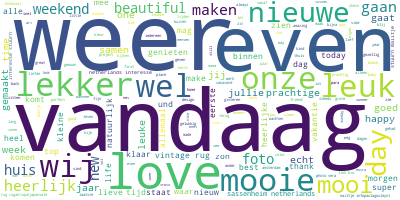

In [359]:

# Join the different processed titles together.
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud

#wordcloud.to_file("data/Wordcloud.png")
wordcloud.to_image()


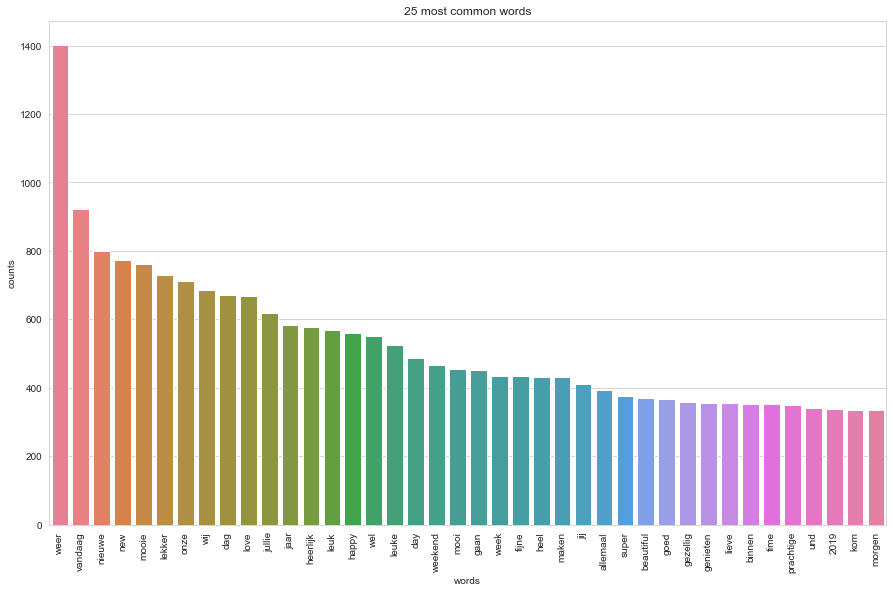

In [360]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:40]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='25 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [361]:
import warnings

warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 20
number_words = 25
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
day old like new beach look blue melli nice mello way party world glass color goodmorning pink house drink love hair amazing sunshine italy pretty

Topic #1:
happy birthday beautiful akjaerbede love know day available 2995 place winter black think friends ill autumn holiday stores selected saturday best stoneware friday girl colors

Topic #2:
fijne a_rashkovskiy mooie avond allemaal iedereen hele gefeliciteerd set vandaag 2020 plukookdezedag dag kerstdagen man uitzicht filmpje fantastisch cute feestdagen 250519 namens gelukkig vaas harte

Topic #3:
2019 link bio kwastenenverf leuk blog shiatsu creamie maken yes mama patroon allemaal jullie leuke xxx kun herfst mooie check geven iedereen gave warme opdracht

Topic #4:
netherlands interesse mailtje sassenheim infopaulagoulmynl stuurn koop stuur info ontwerp mogelijk daimy_sophie verzenden dmpb project prachtig work details wij meiden infozandvoortstudio town progress prachtige materialen

Topic #5:
wij va

In [363]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
    
with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
#with open(LDAvis_data_filepath) as f:
#    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


CPU times: user 40.1 s, sys: 1.19 s, total: 41.3 s
Wall time: 19min 14s


In [289]:
pip install grave

Note: you may need to restart the kernel to use updated packages.
